In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
sns.set(font='IPAexGothic')
from matplotlib.backends.backend_pdf import PdfPages #pdfで保存する

In [2]:
#脱ブタン塔のプロセスデータを読み込む
df = pd.read_csv('debutanizer_data.csv')

# 目的変数の測定誤差を考慮
df['y'] = df['y'].shift(5)

#yがnanとなる期間のデータを削除
df = df.dropna()

#インデックスをリセット
df = df.reset_index(drop=True)

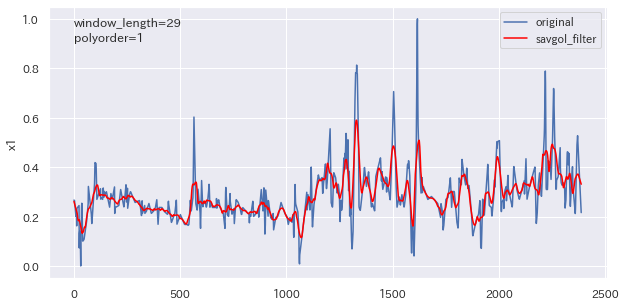

In [3]:
# Savitzky-Golayフィルタ
df_sg = pd.DataFrame(index=df.index)
window_length = 29
polyorder = 1
target_column = 'x1'

df_sg[target_column] = signal.savgol_filter(df[target_column], window_length=window_length, polyorder=polyorder)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df[target_column], label='original')
ax.plot(df_sg, c='red', label='savgol_filter')
ax.set_ylabel('x1')
ax.text(0.75, 0.91, s=f'polyorder={int(polyorder)}')
ax.text(0.75, 0.97, s=f'window_length={int(window_length)}')
ax.legend(loc='best')

# グラフを保存
fig.savefig(f'{target_column}_trend.png')
plt.show()

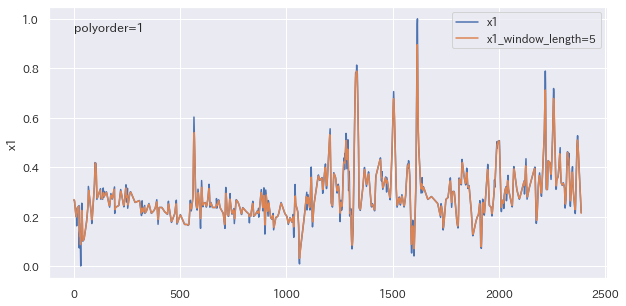

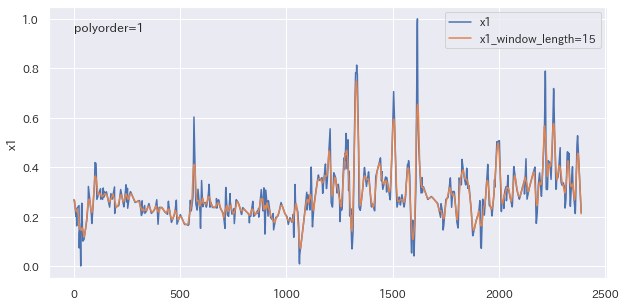

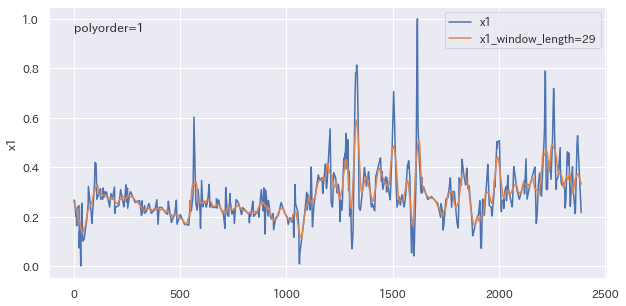

In [4]:
# 空のDataFrameを準備します。ここに平滑化されたデータが保存されます。
df_sg_window = pd.DataFrame()

# Savitzky-Golayフィルタに使用する窓のサイズのリストです。
window_length_list = [5, 15, 29]

# 平滑化を行う特徴量を決めます。
target_column = 'x1'

# 各窓のサイズについてループを行います。
for window_length in window_length_list:
    polyorder = 1
    # 平滑化したデータを計算し、その結果をDataFrameに新しい列として追加します。
    column_name = f'x1_window_length={window_length}'
    df_sg_window[column_name] = signal.savgol_filter(df[target_column], window_length=window_length, polyorder=polyorder)
df_sg_x1_window = pd.concat([df[target_column], df_sg_window], axis=1)

#各列のトレンドグラフを作成
for col in df_sg_x1_window.columns:
    if col == 'x1':
        continue
    else:
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(df_sg_x1_window['x1'], label='x1')
        ax.plot(df_sg_x1_window[col], label=f'{col}')
        ax.set_ylabel('x1')
        ax.text(0.75, 0.95, s=f'polyorder={polyorder}')
        ax.legend(loc='best')
        # グラフを保存
        fig.savefig(f'{col}_trend.png')
        plt.show()
        plt.close(fig)

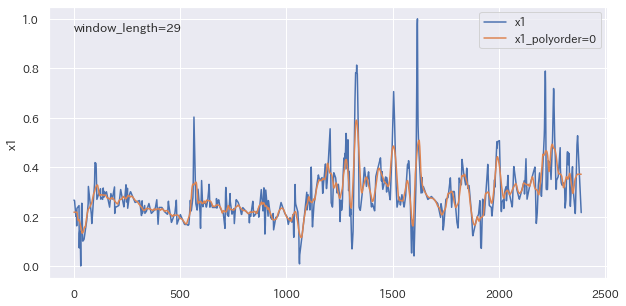

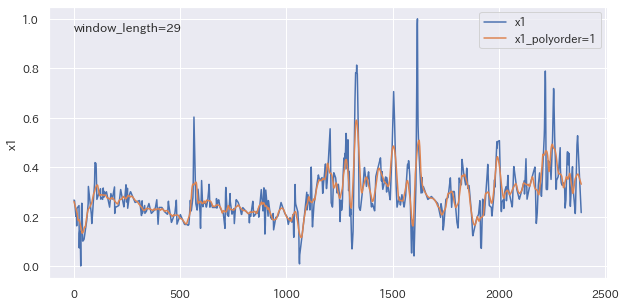

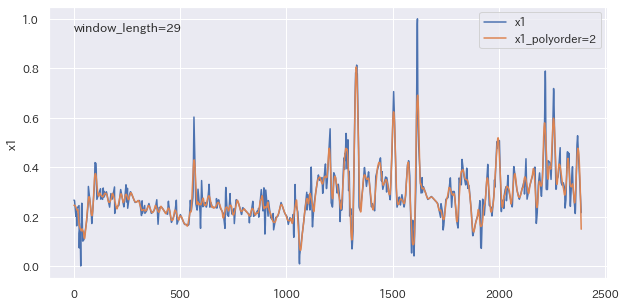

In [5]:
# 空のDataFrameを準備します。ここに平滑化されたデータが保存されます。
df_sg_polyorder = pd.DataFrame()

# Savitzky-Golayフィルタに使用する多項式の次数のリストです。
polyorder_list = range(3)

# 平滑化を行う特徴量を決めます。
target_column = 'x1'

# 次数の数についてループを行います。
for polyorder in polyorder_list:
    window_length = 29
    # 平滑化したデータを計算し、その結果をDataFrameに新しい列として追加します。
    column_name = f'x1_polyorder={polyorder}'
    df_sg_polyorder[column_name] = signal.savgol_filter(df[target_column], window_length=window_length, polyorder=polyorder)
df_sg_x1_polyorder = pd.concat([df[target_column], df_sg_polyorder], axis=1)

#各列のトレンドグラフを作成します。
for col in df_sg_x1_polyorder.columns:
    if col == 'x1':
        continue
    else:
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(df_sg_x1_polyorder['x1'], label='x1')
        ax.plot(df_sg_x1_polyorder[col], label=f'{col}')
        ax.set_ylabel('x1')
        ax.text(0.75, 0.95, s=f'window_length={window_length}')
        ax.legend(loc='best')
        # グラフを保存
        fig.savefig(f'{col}_trend.png')
        plt.show()
        plt.close(fig)

In [6]:
# 空のDataFrameを作成し、パラメータを格納するためのインデックスを設定します
df_param = pd.DataFrame(index=['best_window_length', 'best_polyorder', 'best_pvalue'])

# 空のDataFrameを作成し、元のdfのインデックスを使用してインデックスを設定します
df_sg = pd.DataFrame(index=df.index)

# length_maxまでの奇数をリストに入れる
length_max = 30
window_length_list = []
for i in range(3, length_max):
    if i % 2 != 0:
        window_length_list.append(i)

# savgol_filterのパラメータ探索
for col in df.columns:
    # savgol_filterのパラメータを決める
    best_window_length = 1
    best_polyorder = 0
    best_pvalue = 0 

    # window_length_listをループ
    for window_length in window_length_list:
        # polyorderを0から2まで1ずつ増やしながらループ
        for polyorder in polyorder_list:
            #nanを削除
            df_col = df[col].dropna()
            
            # savgol_filterで平滑化
            y = signal.savgol_filter(df_col, window_length=window_length, polyorder=polyorder)
            
            # normaltestで正規性の検定（ダゴスティーノ・ピアソン検定）
            _, pvalue1 = sp.stats.normaltest(df_col - y)
            
            # shapiroで正規性の検定（シャピロ・ウィルク検定）
            _, pvalue2 = sp.stats.shapiro(df_col - y)
            
            # kstestで正規生の検定（コルモゴロフ・スミルノフ検定）
            # データの平均と標準偏差を計算
            mean = df_col.mean()
            std = df_col.std(ddof=1)
            
            # 標準正規分布の平均と標準偏差を調整して検定
            _, pvalue3 = sp.stats.kstest(df_col, 'norm', args=(mean, std))
            
            # 三つの検定のp値の最小値を取る
            pvalue = max(pvalue1, pvalue2, pvalue3)  # p値
            
            # p値が最大値を更新したら、best_window_lengthとbest_polyorderを更新する
            if pvalue > best_pvalue:
                best_window_length = window_length
                best_polyorder = polyorder
                best_pvalue = pvalue
    # savgol_filterのパラメータをDataframeに格納
    df_param[col] = [best_window_length, best_polyorder, best_pvalue]
    
    # 平滑化したデータをDataframeに格納
    df_sg[col] = signal.savgol_filter(df_col, window_length=best_window_length, polyorder=best_polyorder)
# savgol_filterのパラメータを保存
df_param.to_excel('sg_parameter.xlsx')

# 平滑化したデータを保存
df_sg.to_excel('savgol_filter_data.xlsx')
df_sg.to_pickle('savgol_filter_sgdata.pkl')

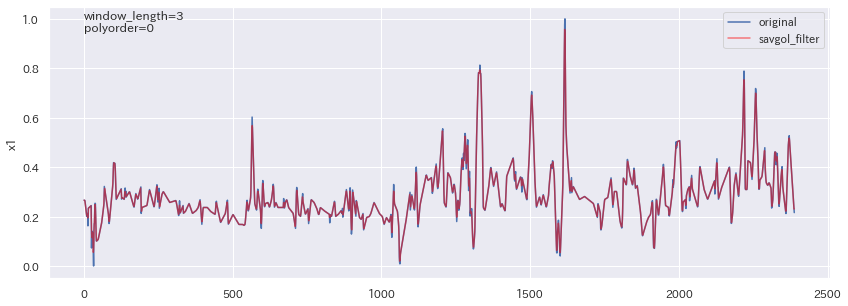

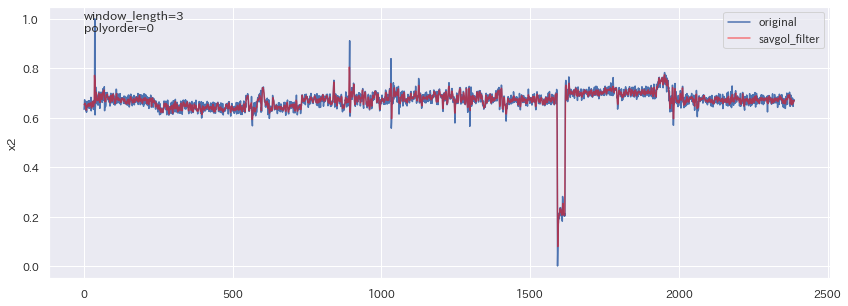

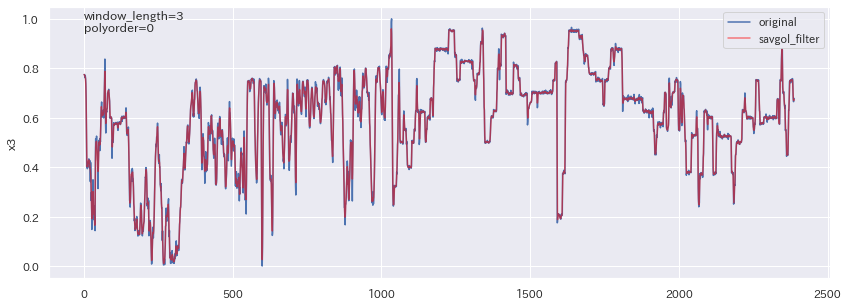

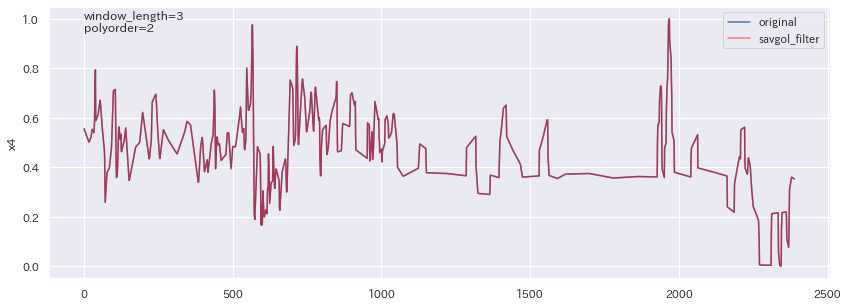

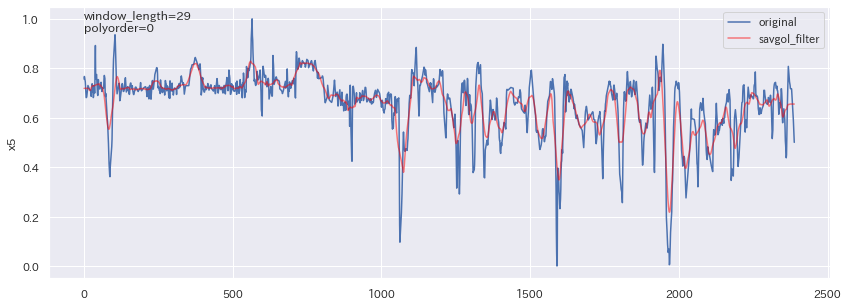

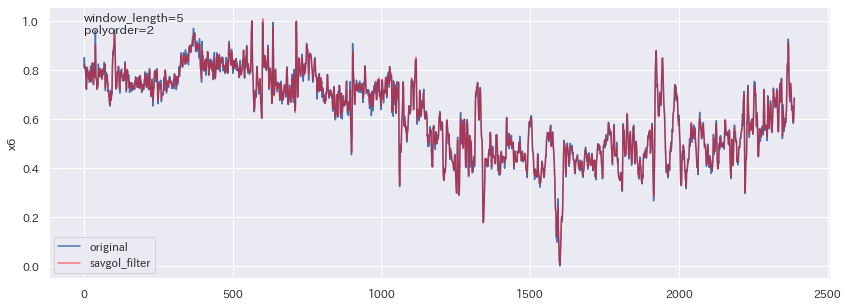

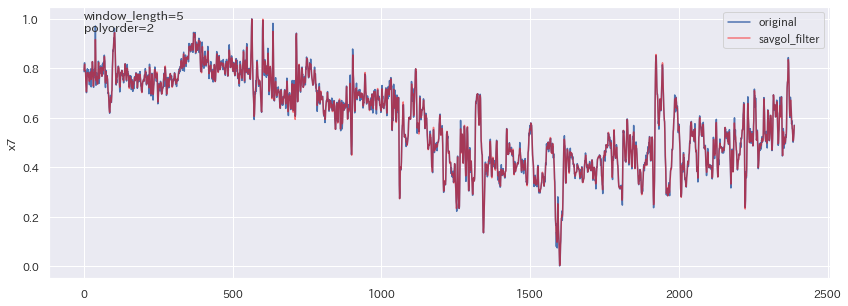

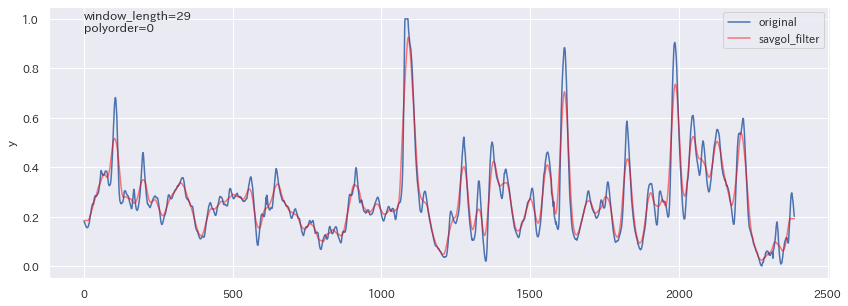

In [7]:
#pdfで保存するためpdfインスタンスを作成
pdf = PdfPages('debutanizer_sg_trend.pdf')

# dfの各列（col）について、トレンドデータを可視化します
for col in df.columns:
    # グラフのフィギュア（全体）とその中の描画領域（ax）を作成します
    fig, ax =plt.subplots(figsize=(14,5)) 
    
    # 元のデータ（dfのcol列）をプロットします。
    ax.plot(df[col], label='original')
    
    # 平滑化したデータ（df_sgのcol列）をプロットします。透明度（alpha）を0.5として設定します
    ax.plot(df_sg[col], color='red', alpha=0.5, label='savgol_filter')
    
    # y軸のラベルを設定します
    ax.set_ylabel(col)
    ax.text(0.60, 1.00, s=f'window_length={int(df_param[col][0])}')
    ax.text(0.60, 0.95, s=f'polyorder={int(df_param[col][1])}')    
    
    # 凡例を表示します
    ax.legend(loc='best')
    
    # グラフを画面に表示します
    plt.show()
    
    # グラフをpdfファイルに保存します
    pdf.savefig(fig)
    
    # グラフをpng画像としても保存します
    fig.savefig(f'{col}_sg_trend.png', dpi=150)
    
    # メモリの節約と次のループへの準備のため、現在のフィギュアを閉じます
    plt.close(fig)
# すべてのグラフを描画し終えたら、pdfファイルを閉じて保存します
pdf.close() 